# PROGRAM GIVING LONDON LOCATION OPTIONS OF WHERE TO START NEW BUSINESS  

## Coursera Module 10 - Final Assignment 

By Oliver Harrison

In [1]:
#Main Libraries

import json # library to handle JSON files
import numpy as np # library to handle data in a vectorized manner
!pip install geopy
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans
!pip install beautifulsoup4
from bs4 import BeautifulSoup
import requests as r # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
print('Main Libraries imported.')


Main Libraries imported.


# London Criteria

The dictionary will contain characteristic information on the client's new business so that the program can best recommend areas to avoid and areas to consider.

In [2]:
BusinessCriteria = {
    'Business' : "Restaurant", # Find an area of which there are fewer restaurants thus have need of a new one
    'Cuisine' : "Italian", # find an area without many italinen resturants
    'Price' : "Cheap", #Good to be in an richer area to 
    'Radius' : 5500 , #5km radis around the center
    'NESW' : "E" , #Wants the restaurant to be in the east of london
    'Reference_Lat' : 51.5073219,
    'Reference_Lon' :  -0.1276474
    
}

## Processing London Boroughs

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_London_boroughs"

wiki_page_request = r.get(url)
wiki_page = wiki_page_request.text

In [4]:
soup = BeautifulSoup(wiki_page, 'html.parser')

#Looking for the main table
mainTable = soup.find_all('table', class_='wikitable')

# print(mainTable)

In [5]:
def boroughAssigner(allTables):
    
    tempBorough = {
        'Headings' : [],
        'Borough' : [],
        'Area':[],
        'Population':[],
        'Coordinates':[],
        'Latitude': [],
        'Longitude': [],
        'Cardinal_Lat': [],
        'Cardinal_Lon': []
    }
 
    ## THE HEADING IS SIMPLY THE FIRST ROW ##
    heading_rows = allTables[0].find_all('tr')
    headings1 = heading_rows[0].findAll('th') #Stations are stored in a th 
    
    tempBorough['Headings'].append(headings1[0].get_text(strip=True))
    tempBorough['Headings'].append(headings1[6].get_text(strip=True))
    tempBorough['Headings'].append(headings1[7].get_text(strip=True))
    tempBorough['Headings'].append(headings1[8].get_text(strip=True))
#     print("\n\ntempBorough['Headings']: \n", tempBorough['Headings'])
    

    
    for row in allTables[0].find_all('tr'):
        
        columns = row.findAll('td')
        
        ## THE REST IS A CELL FROM EACH OF THE ROWS
        ## --having problem with count, starts at 1 then is either 15,16,18 -- could be to do with tagging
#         print("\nLength of Columns: \n", len(columns))

        if len(columns) != 0 :
        
        
            borough_to_clean = columns[0].get_text(strip=True)
            clean_borough = ""
            
            if "[note 1]" in borough_to_clean:
                print("\nCleaning: [note 1] ")
                clean_borough = borough_to_clean.replace("[note 1]","")
                
            elif "[note 2]" in borough_to_clean:
                print("\nCleaning: [note 2] ")
                clean_borough = borough_to_clean.replace("[note 2]","")
                
            elif "[note 3]" in borough_to_clean:
                print("\nCleaning: [note 3] ")
                clean_borough = borough_to_clean.replace("[note 3]","")
                
            elif "[note 4]" in borough_to_clean:
                print("\nCleaning: [note 4] ")
                clean_borough = borough_to_clean.replace("[note 4]","")
                
            else:
#                 print("\nNo Issues")
                clean_borough = borough_to_clean
                
                
            tempBorough['Borough'].append(clean_borough)
            tempBorough['Area'].append(columns[6].get_text(strip=True))
            tempBorough['Population'].append(columns[7].get_text(strip=True))
            ##Extra filtering into lat/long
            lat_lon = columns[8].find('span',class_='geo-dec')
            tempBorough['Coordinates'].append(lat_lon.get_text(strip=True))
                   
#             print("\n-------------- LETS GOOO ! ------------\n\nShould be Borough\n", tempBorough['Borough'] )
#             print("\nShould be Area - 6th Column: \n", tempBorough['Area'] )
#             print("\nShould be Population - 8th Column:\n", tempBorough['Population'] )
#             print("\nShould be Coordinates - 9th Column:\n", tempBorough['Coordinates'] )



    return tempBorough

London_data = boroughAssigner(mainTable)
print("\n\nFinal Table: \n", London_data)


Cleaning: [note 1] 

Cleaning: [note 2] 

Cleaning: [note 4] 


Final Table: 
 {'Headings': ['Borough', 'Area (sq mi)', 'Population (2019 est)[1]', 'Co-ordinates'], 'Borough': ['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'], 'Area': ['13.93', '33.49', '23.38', '16.70', '57.97', '8.40', '33.41', '21.44', '31.74', '18.28', '7.36', '6.33', '11.42', '19.49', '43.35', '44.67', '21.61', '5.74', '4.68', '14.38', '10.36', '13.57', '14.52', '13.98', '21.78', '22.17', '11.14', '16.93', '7.63', '14.99', '13.23', '8.29'], 'Population': ['212,906', '395,896', '248,287', '329,771', '332,336', '270,029', '38

## Convert Coordinates into Separate Latitude and Longitude

In [6]:
count = 0

#Clear list to start
London_data['Latitude'].clear()
London_data['Longitude'].clear()

for coord in London_data['Coordinates']:
#     print(count)
    # Split the text wherever there's a full stop.
    a,b = coord.split()
    
    #Now remove the °N/E/W/S (Convert the west to a minus number)
    new_a = a.replace('°N','')
    
    if "°E" in b:
#         print("\nCurrent value: ", b)
        new_b = b.replace('°E','')
#         print("$$ HIT WITH E at: ", new_b)
        
    elif "°W" in b:
#         print("\nCurrent value: ", b)
        new_b = b.replace('°W','')
        new_b = "-" + new_b
#         print("$$ HIT WITH W at: ", new_b)
    else:
        print("\n** Problem with N/E")
        
    
    #Convert sting to integar
    
    float_a = float(new_a)
    float_b = float(new_b)
    
#     print("\nType of float_a:", type(float_a))
    
    London_data['Latitude'].append(float_a)
    London_data['Longitude'].append(float_b)

    # Display the results.
#     print(new_a)
#     print(new_b)
#     count += 1
  

### Finding the Cardinal Direction for each Borough with references to the set location (Center of London)

In [7]:
for (Lati, Long) in zip(London_data['Latitude'], London_data['Longitude']) :
  
## LOOKING AT N/S 
    if Lati > BusinessCriteria["Reference_Lat"]:
        London_data["Cardinal_Lat"].append("N")
#         print("\n $$ N")
        
    elif Lati < BusinessCriteria["Reference_Lat"]:
        London_data["Cardinal_Lat"].append("S")
#         print("\n $$ S")
        
    else:
        print("\n ** ERROR WITH N & S CARDINAL")
        
## LOOKING AT E/W        
    if Long > BusinessCriteria["Reference_Lon"]:
        London_data["Cardinal_Lon"].append("E")
#         print("\n $$ E")
        
    elif Long < BusinessCriteria["Reference_Lon"]:
        London_data["Cardinal_Lon"].append("W")
#         print("\n $$ W")
    else:
        print("\n ** ERROR WITH E & W CARDINAL")
    
    

### Cheking shape of London_data

In [8]:


print(len(London_data))
print(len(London_data['Borough']))
print(len(London_data['Area']))
print(len(London_data['Population']))
print(len(London_data['Coordinates']))
print(len(London_data['Latitude']))
print(len(London_data['Longitude']))
print(len(London_data['Cardinal_Lat']))
print(len(London_data['Cardinal_Lon']))



9
32
32
32
32
32
32
32
32


## Creating a Dataframe in order to present the data

In [9]:

#Saving heading and deleting it from pop as dataframe requires same length arrays
headings = London_data['Headings']
London_data.pop('Headings')

london_data =pd.DataFrame(London_data)
london_data.head()

,Borough,Area,Population,Coordinates,Latitude,Longitude,Cardinal_Lat,Cardinal_Lon
0,Barking and Dagenham,13.93,"212,906",51.5607°N 0.1557°E,51.5607,0.1557,N,E
1,Barnet,33.49,"395,896",51.6252°N 0.1517°W,51.6252,-0.1517,N,W
2,Bexley,23.38,"248,287",51.4549°N 0.1505°E,51.4549,0.1505,S,E
3,Brent,16.70,"329,771",51.5588°N 0.2817°W,51.5588,-0.2817,N,W
4,Bromley,57.97,"332,336",51.4039°N 0.0198°E,51.4039,0.0198,S,E


## Analysing the data using skills learned from the NYC Lab

In [10]:
CLIENT_ID = 'IOY1YSRI0NMT15F5Q5YWGDCG1OTE0ZEXAJDA3E4RGKCECN2E' # My Foursquare ID
CLIENT_SECRET = 'FDNPUYQSV0HH05UYWIZJVB5KZ1SZ1LOEDR1DALT0MQIUZG4J' # My Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentails:
CLIENT_ID: IOY1YSRI0NMT15F5Q5YWGDCG1OTE0ZEXAJDA3E4RGKCECN2E
CLIENT_SECRET:FDNPUYQSV0HH05UYWIZJVB5KZ1SZ1LOEDR1DALT0MQIUZG4J


## Creating a Circle Around London to Highlight and Map out the Different Boroughs

In [11]:
address = 'London, UK'

geolocator = Nominatim(user_agent="ldn_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London City are 51.5073219, -0.1276474.


In [12]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

print("TYPE OF london_data['Latitude']", type(london_data['Latitude']))

# add markers to map
for lat, lng, borough in zip(london_data['Latitude'], london_data['Longitude'], london_data['Borough']):
    
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  

# #Testing the west with red pin    
# folium.CircleMarker(
#         [51.5130, -0.3089],
#         radius=5,
#         popup="hello",
#         color='red',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_london)


map_london



TYPE OF london_data['Latitude'] <class 'pandas.core.series.Series'>


In [13]:
neighbourhood_latitude = london_data.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = london_data.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = london_data.loc[0, 'Borough'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

#First set radius and limit.

LIMIT = 100

radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

url

Latitude and longitude values of Barking and Dagenham are 51.5607, 0.1557.


'https://api.foursquare.com/v2/venues/explore?&client_id=IOY1YSRI0NMT15F5Q5YWGDCG1OTE0ZEXAJDA3E4RGKCECN2E&client_secret=FDNPUYQSV0HH05UYWIZJVB5KZ1SZ1LOEDR1DALT0MQIUZG4J&v=20180605&ll=51.5073219,-0.1276474&radius=500&limit=100'

## Using the URL produced above, We are going to find info in the areas

In [14]:
results = r.get(url).json()
# results

In [15]:
# print(results)

In [16]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [17]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,National Gallery,Art Museum,51.508876,-0.128478
1,Trafalgar Square,Plaza,51.507987,-0.128048
2,Corinthia Hotel,Hotel,51.506607,-0.124460
3,Sainsbury Wing National Gallery,Art Museum,51.508384,-0.129001
4,East Trafalgar Square Fountain,Fountain,51.508088,-0.127700


In [18]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = r.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
london_venues = getNearbyVenues(names=london_data['Borough'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude'])

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [21]:
#Size Check
print(london_venues.shape)
london_venues.head()

(1445, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket
1,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
2,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts School
3,Barking and Dagenham,51.5607,0.1557,Becontree Heath Bus Station,51.561065,0.150998,Bus Station
4,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center


In [22]:
london_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Barking and Dagenham,7,7,7,7,7,7
Barnet,3,3,3,3,3,3
Bexley,28,28,28,28,28,28
Brent,76,76,76,76,76,76
Bromley,38,38,38,38,38,38
Camden,79,79,79,79,79,79
Croydon,35,35,35,35,35,35
Ealing,73,73,73,73,73,73
Enfield,50,50,50,50,50,50


In [23]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 210 uniques categories.


## Analysing Each Neighbourhood

In [24]:

# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
london_onehot['Neighbourhood'] = london_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighbourhood,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoothie Shop,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [25]:
london_onehot.shape

(1445, 211)

In [26]:

london_grouped = london_onehot.groupby('Neighbourhood').mean() .reset_index()
london_grouped.head()

,Neighbourhood,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Australian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Light Rail Station,Lighting Store,Liquor Store,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Outdoor Supply Store,Outlet Mall,Outlet Store,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Road,Roof Deck,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoothie Shop,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.142857,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.142857,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.142857,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0

In [27]:
london_grouped.shape

(32, 211)

## Top Venues in each Neighbourhood

In [28]:
num_top_venues = 5

for hood in london_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                 venue  freq
0                 Pool  0.14
1                 Park  0.14
2          Supermarket  0.14
3          Golf Course  0.14
4  Martial Arts School  0.14


----Barnet----
                venue  freq
0                Café  0.67
1            Bus Stop  0.33
2  African Restaurant  0.00
3        Outlet Store  0.00
4           Newsagent  0.00


----Bexley----
                    venue  freq
0          Clothing Store  0.14
1                     Pub  0.11
2             Supermarket  0.07
3             Coffee Shop  0.07
4  Furniture / Home Store  0.07


----Brent----
                 venue  freq
0          Coffee Shop  0.09
1                Hotel  0.08
2                  Bar  0.07
3       Clothing Store  0.05
4  Sporting Goods Shop  0.05


----Bromley----
            venue  freq
0  Clothing Store  0.16
1     Coffee Shop  0.13
2     Pizza Place  0.05
3    Burger Joint  0.05
4             Bar  0.05


----Camden----
         venue  freq
0  Coffee Sho

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Park,Martial Arts School,Supermarket,Golf Course,Gym / Fitness Center,Bus Station,Dumpling Restaurant,Donut Shop,French Restaurant
1,Barnet,Café,Bus Stop,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Flea Market,Fish Market
2,Bexley,Clothing Store,Pub,Pharmacy,Coffee Shop,Fast Food Restaurant,Furniture / Home Store,Supermarket,Plaza,Bakery,Portuguese Restaurant
3,Brent,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Grocery Store,American Restaurant,Burger Joint,Indian Restaurant,Italian Restaurant
4,Bromley,Clothing Store,Coffee Shop,Pizza Place,Burger Joint,Bar,Gym / Fitness Center,Furniture / Home Store,Portuguese Restaurant,Sandwich Place,Café


## Klustering the Neighbourhods

In [31]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 3, 3, 3, 1, 1, 3, 3, 3], dtype=int32)

In [32]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [33]:

london_merged = london_data

# merge london_grouped with london_data to add latitude/longitude for each neighbourhood *** CONFUSING AS I HAVE NOT USED NEIGBOURHOODS THROUGHT THIS TASK
london_merged = london_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Borough')

london_merged.head() # check the last columns!

,Borough,Area,Population,Coordinates,Latitude,Longitude,Cardinal_Lat,Cardinal_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,13.93,"212,906",51.5607°N 0.1557°E,51.5607,0.1557,N,E,1,Pool,Park,Martial Arts School,Supermarket,Golf Course,Gym / Fitness Center,Bus Station,Dumpling Restaurant,Donut Shop,French Restaurant
1,Barnet,33.49,"395,896",51.6252°N 0.1517°W,51.6252,-0.1517,N,W,2,Café,Bus Stop,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Flea Market,Fish Market
2,Bexley,23.38,"248,287",51.4549°N 0.1505°E,51.4549,0.1505,S,E,3,Clothing Store,Pub,Pharmacy,Coffee Shop,Fast Food Restaurant,Furniture / Home Store,Supermarket,Plaza,Bakery,Portuguese Restaurant
3,Brent,16.70,"329,771",51.5588°N 0.2817°W,51.5588,-0.2817,N,W,3,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Grocery Store,American Restaurant,Burger Joint,Indian Restaurant,Italian Restaurant
4,Bromley,57.97,"332,336",51.4039°N 0.0198°E,51.4039,0.0198,S,E,3,Clothing Store,Coffee Shop,Pizza Place,Burger Joint,Bar,Gym / Fitness Center,Furniture / Home Store,Portuguese Restaurant,Sandwich Place,Café


## Time to visualise the dataframe

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'],london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Looking into the Clusters

### Cluster 1

In [35]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area,Longitude,Cardinal_Lat,Cardinal_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,21.61,-0.368,S,W,0,Indian Restaurant,Café,Park,Restaurant,Fast Food Restaurant,Yoga Studio,Event Space,Food Truck,Food Court,Flea Market


### Cluster 2

In [36]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]



,Area,Longitude,Cardinal_Lat,Cardinal_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,13.93,0.1557,N,E,1,Pool,Park,Martial Arts School,Supermarket,Golf Course,Gym / Fitness Center,Bus Station,Dumpling Restaurant,Donut Shop,French Restaurant
5,8.40,-0.1255,N,E,1,Hotel,Coffee Shop,Café,Pub,Modern European Restaurant,Restaurant,Burger Joint,Breakfast Spot,Deli / Bodega,Bakery
6,33.41,-0.0977,S,E,1,Pub,Korean Restaurant,Portuguese Restaurant,Coffee Shop,Asian Restaurant,Malay Restaurant,Bookstore,Breakfast Spot,Brewery,Burger Joint
10,7.36,-0.0553,N,E,1,Pub,Coffee Shop,Bakery,Brewery,Park,Cocktail Bar,Café,Organic Grocery,Clothing Store,Vegetarian / Vegan Restaurant
11,6.33,-0.2339,S,W,1,Pub,Café,Italian Restaurant,Indian Restaurant,Chinese Restaurant,Gastropub,Clothing Store,Hotel,Vietnamese Restaurant,Grocery Store
12,11.42,-0.1119,N,E,1,Café,Park,Turkish Restaurant,Bakery,Light Rail Station,Fast Food Restaurant,Supermarket,Movie Theater,Grocery Store,Pub
17,5.74,-0.1022,N,E,1,Pub,Theater,Ice Cream Shop,Burger Joint,Café,Cocktail Bar,Park,Bakery,Boutique,Music Venue
18,4.68,-0.1947,S,W,1,Café,Juice Bar,Hotel,Restaurant,Clothing Store,Bakery,Department Store,Italian Restaurant,French Restaurant,Burger Joint
20,10.36,-0.1163,S,E,1,Pub,Coffee Shop,Caribbean Restaurant,Market,Restaurant,Café,Gym / Fitness Center,Pizza Place,Beer Bar,Indian Restaurant
26,11.14,-0.0804,S,E,1,Coffee Shop,Pub,Bar,Grocery Store,French Restaurant,Scenic Lookout,Thai Restaurant,Restaurant,Hotel,Pizza Place


### Cluster 3

In [37]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]


,Area,Longitude,Cardinal_Lat,Cardinal_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,33.49,-0.1517,N,W,2,Café,Bus Stop,Yoga Studio,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Truck,Food Court,Flea Market,Fish Market


### Cluster 4

In [38]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]


,Area,Longitude,Cardinal_Lat,Cardinal_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,23.38,0.1505,S,E,3,Clothing Store,Pub,Pharmacy,Coffee Shop,Fast Food Restaurant,Furniture / Home Store,Supermarket,Plaza,Bakery,Portuguese Restaurant
3,16.70,-0.2817,N,W,3,Coffee Shop,Hotel,Bar,Clothing Store,Sporting Goods Shop,Grocery Store,American Restaurant,Burger Joint,Indian Restaurant,Italian Restaurant
4,57.97,0.0198,S,E,3,Clothing Store,Coffee Shop,Pizza Place,Burger Joint,Bar,Gym / Fitness Center,Furniture / Home Store,Portuguese Restaurant,Sandwich Place,Café
7,21.44,-0.3089,N,W,3,Coffee Shop,Clothing Store,Park,Italian Restaurant,Pub,Bakery,Café,Pizza Place,Burger Joint,Hotel
8,31.74,-0.0799,N,E,3,Coffee Shop,Clothing Store,Supermarket,Pub,Optical Shop,Sandwich Place,Video Game Store,Department Store,Gift Shop,Pharmacy
9,18.28,0.0648,S,E,3,Pub,Fast Food Restaurant,Coffee Shop,Supermarket,Clothing Store,Pharmacy,Platform,Hotel,Plaza,Grocery Store
13,19.49,-0.3346,N,W,3,Indian Restaurant,Platform,Train Station,Supermarket,Grocery Store,Coffee Shop,Thai Restaurant,Indie Movie Theater,Diner,Falafel Restaurant
14,43.35,0.1837,N,E,3,Coffee Shop,Clothing Store,Shopping Mall,Fast Food Restaurant,Café,Hotel,Bakery,Pub,Bookstore,Newsagent
15,44.67,-0.4760,N,W,3,Coffee Shop,Clothing Store,Fast Food Restaurant,Pharmacy,Pub,Shopping Mall,Toy / Game Store,Burger Joint,Italian Restaurant,Sandwich Place
19,14.38,-0.3064,S,W,3,Coffee Shop,Clothing Store,Café,Pub,Italian Restaurant,Burger Joint,Department Store,Bakery,Sushi Restaurant,Sandwich Place


### Cluster 5

In [39]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]


,Area,Longitude,Cardinal_Lat,Cardinal_Lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,13.98,0.0469,N,E,4,Hotel,Sandwich Place,Chinese Restaurant,Airport Lounge,Airport Service,Pharmacy,Rafting,Light Rail Station,Food Truck,Food Court


# Algorithm to find best place to 'set-up shop' using data above and the clients business criteria

In [40]:
# Quick refresh of the dictionary

print(BusinessCriteria)

{'Business': 'Restaurant', 'Cuisine': 'Italian', 'Price': 'Cheap', 'Radius': 5500, 'NESW': 'E', 'Reference_Lat': 51.5073219, 'Reference_Lon': -0.1276474}


## 1. Using the radius preference, we are going to plot a circle around London, indicating the furthest this buisness owner wants to set up shop.

In [41]:
# create map
map_limit = folium.Map(location=[latitude, longitude], zoom_start=11)

print(latitude, longitude)
folium.Circle(
    [latitude, longitude],
    radius= BusinessCriteria['Radius'],
    popup= "Limit Radius to set up shop",
    color= 'red',
    fill=True,
    fill_opacity = '10%',
    fill_color='red').add_to(map_limit)
       
map_limit

51.5073219 -0.1276474


### Create Semi Circle of the cardinal direction: 

We now need to look at the direction where the buisness wants to be N E S W

In [42]:
# # from folium import plugins
# # from folium.plugins import SemiCircle

# #Using the semicircle tool, we are going to highlight the cardinal direction

# print(dir(folium))


# def SemiCircleo(location, radius, azimute, arc):
#     SemiCircle(
#         location=location,   # Location of center
#         radius= radius,               # Radius in meters
#         direction = azimute,              # Stop angle (0 to 360 degrees)
#         arc = arc
#     ).add_to(map_limit)
    
    
# arc = 180

# if BusinessCriteria['NESW'] == 'N':
#     azimute = 90
#     SemiCircleo(location, radius, azimute, arc)
    
# elif BusinessCriteria['NESW'] == 'E':
#     print("\n\n** HIT @ E **")
#     azimute = 20
#     SemiCircleo(location, radius, azimute, arc)
    
# elif BusinessCriteria['NESW'] == 'S':
#     print("\n\n** HIT @ S **")
#     azimute = 270
#     SemiCircleo(location, radius, azimute, arc)
    
# elif BusinessCriteria['NESW'] == 'W':
#     print("\n\n** HIT @ W **")
#     azimute = 360
#     SemiCircleo(location, radius, azimute, arc)
    
# map_limit    

### Filtering all of the Boroughs to display those which are in the business' preferred direction. 

In [43]:
#Copied the dictionary so that values won't be permenently deleted
filter_london_data = london_data

if "E" in BusinessCriteria['NESW']:
    print("\n $ Hit @ E")
    filter_london_data = filter_london_data[~filter_london_data.Cardinal_Lon.str.contains("W")]

elif "W" in BusinessCriteria['NESW']:
    filter_london_data = filter_london_data[~filter_london_data.Cardinal_Lon.str.contains("E")]

elif "N" in BusinessCriteria['NESW']:
    filter_london_data = filter_london_data[~filter_london_data.Cardinal_Lat.str.contains("S")]

elif "S" in BusinessCriteria['NESW']:
    filter_london_data = filter_london_data[~filter_london_data.Cardinal_Lat.str.contains("N")]




filter_london_data
    


 $ Hit @ E


,Borough,Area,Population,Coordinates,Latitude,Longitude,Cardinal_Lat,Cardinal_Lon
0,Barking and Dagenham,13.93,"212,906",51.5607°N 0.1557°E,51.5607,0.1557,N,E
2,Bexley,23.38,"248,287",51.4549°N 0.1505°E,51.4549,0.1505,S,E
4,Bromley,57.97,"332,336",51.4039°N 0.0198°E,51.4039,0.0198,S,E
5,Camden,8.40,"270,029",51.5290°N 0.1255°W,51.5290,-0.1255,N,E
6,Croydon,33.41,"386,710",51.3714°N 0.0977°W,51.3714,-0.0977,S,E
8,Enfield,31.74,"333,794",51.6538°N 0.0799°W,51.6538,-0.0799,N,E
9,Greenwich,18.28,"287,942",51.4892°N 0.0648°E,51.4892,0.0648,S,E
10,Hackney,7.36,"281,120",51.5450°N 0.0553°W,51.5450,-0.0553,N,E
12,Haringey,11.42,"268,647",51.6000°N 0.1119°W,51.6000,-0.1119,N,E
14,Havering,43.35,"259,552",51.5812°N 0.1837°E,51.5812,0.1837,N,E


In [44]:


# add markers to map
for lat, lng, borough in zip(filter_london_data['Latitude'], filter_london_data['Longitude'], filter_london_data['Borough']):
    
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_limit)  

# #Testing the west with red pin    
# folium.CircleMarker(
#         [51.5130, -0.3089],
#         radius=5,
#         popup="hello",
#         color='red',
#         fill=True,
#         fill_color='#3186cc',
#         fill_opacity=0.7,
#         parse_html=False).add_to(map_london)


map_limit





## Need to remove those Boroughs out of the radius limit

In [45]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6373.0

lat1 = radians(BusinessCriteria['Reference_Lat'])
lon1 = radians(BusinessCriteria['Reference_Lon'])
lat2 = radians(52.406374)
lon2 = radians(16.9251681)

dlon = lon2 - lon1
dlat = lat2 - lat1

a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
c = 2 * atan2(sqrt(a), sqrt(1 - a))

distance = R * c

print("Result:", distance)
print("Should be:", 278.546, "km")

Result: 1170.4269721770409
Should be: 278.546 km


In [46]:
count = 0

## 0.4 is equivilent to 5k radius



for lat_, lng_, borough in zip(filter_london_data['Latitude'], filter_london_data['Longitude'], filter_london_data['Borough']):
    
    #Applies to East direction
    print("lon {} >= {}".format(lng_, (BusinessCriteria['Reference_Lon'] + 0.4) )) 
    if (lat_ >= (BusinessCriteria['Reference_Lat'] + 0.4)) or (lat_ <= ((BusinessCriteria['Reference_Lat'] - 0.4))):
        print("count: {} Dropped {}".format(count, borough))
        filter_london_data.drop(count,axis=0)
        
                                                      
    elif lng_ > (BusinessCriteria['Reference_Lon'] + 0.42):
        print("count: {} Dropped {}".format(count, borough))
        filter_london_data.drop(count,axis=0)
        
    
    count += 1
    
    
filter_london_data    
    

lon 0.1557 >= 0.27235260000000006
lon 0.1505 >= 0.27235260000000006
lon 0.0198 >= 0.27235260000000006
lon -0.1255 >= 0.27235260000000006
lon -0.0977 >= 0.27235260000000006
lon -0.0799 >= 0.27235260000000006
lon 0.0648 >= 0.27235260000000006
lon -0.0553 >= 0.27235260000000006
lon -0.1119 >= 0.27235260000000006
lon 0.1837 >= 0.27235260000000006
lon -0.1022 >= 0.27235260000000006
lon -0.1163 >= 0.27235260000000006
lon -0.0209 >= 0.27235260000000006
lon 0.0469 >= 0.27235260000000006
lon 0.0741 >= 0.27235260000000006
lon -0.0804 >= 0.27235260000000006
lon -0.0059 >= 0.27235260000000006
lon -0.0134 >= 0.27235260000000006


,Borough,Area,Population,Coordinates,Latitude,Longitude,Cardinal_Lat,Cardinal_Lon
0,Barking and Dagenham,13.93,"212,906",51.5607°N 0.1557°E,51.5607,0.1557,N,E
2,Bexley,23.38,"248,287",51.4549°N 0.1505°E,51.4549,0.1505,S,E
4,Bromley,57.97,"332,336",51.4039°N 0.0198°E,51.4039,0.0198,S,E
5,Camden,8.40,"270,029",51.5290°N 0.1255°W,51.5290,-0.1255,N,E
6,Croydon,33.41,"386,710",51.3714°N 0.0977°W,51.3714,-0.0977,S,E
8,Enfield,31.74,"333,794",51.6538°N 0.0799°W,51.6538,-0.0799,N,E
9,Greenwich,18.28,"287,942",51.4892°N 0.0648°E,51.4892,0.0648,S,E
10,Hackney,7.36,"281,120",51.5450°N 0.0553°W,51.5450,-0.0553,N,E
12,Haringey,11.42,"268,647",51.6000°N 0.1119°W,51.6000,-0.1119,N,E
14,Havering,43.35,"259,552",51.5812°N 0.1837°E,51.5812,0.1837,N,E


## ** RAN INTO PROBLEMS WHEN TRING TO DROP ROWS WHICH ARE OT IN THE CIRCLES PERIMETER
## ** SO IT IS GOING TO BE DONE MANUALLY...

In [47]:
#AS SEEN ABOVE, THE FOR BOROUGHS IN THE RED CIRCLE ARE
# ISLINGTON, CAMDEN, LAMBETH, SOUTHWARK

for borough in filter_london_data['Borough']:
    if (borough != "Islington") and (borough != "Camden") and (borough !="Lambeth") and (borough != "Southwark"):
        filter_london_data = filter_london_data[~filter_london_data.Borough.str.contains(borough)]

filter_london_data

,Borough,Area,Population,Coordinates,Latitude,Longitude,Cardinal_Lat,Cardinal_Lon
5,Camden,8.40,"270,029",51.5290°N 0.1255°W,51.5290,-0.1255,N,E
17,Islington,5.74,"242,467",51.5416°N 0.1022°W,51.5416,-0.1022,N,E
20,Lambeth,10.36,"326,034",51.4607°N 0.1163°W,51.4607,-0.1163,S,E
26,Southwark,11.14,"318,830",51.5035°N 0.0804°W,51.5035,-0.0804,S,E


### Now that we have completed our first filter, We are going to look at area with the fewest "Business type"

- SO if for example it is a restaurant, we are going to consider the borough with the fewest restaurants in the direction (This example being east)

# Lowest occurrence of Restaurants

In [48]:
filtered_london_venues = getNearbyVenues(names=filter_london_data['Borough'],
                                   latitudes=filter_london_data['Latitude'],
                                   longitudes=filter_london_data['Longitude'])

Camden
Islington
Lambeth
Southwark


In [49]:
#Size Check
print(filtered_london_venues.shape)
filtered_london_venues.head()

(325, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Camden,51.529,-0.1255,The Sir John Ritblat Gallery: Treasures of the...,51.529666,-0.127541,Museum
1,Camden,51.529,-0.1255,Double Standard,51.529464,-0.124428,Hotel Bar
2,Camden,51.529,-0.1255,Origin Coffee Roasters,51.529133,-0.126618,Coffee Shop
3,Camden,51.529,-0.1255,Pullman London St Pancras,51.528668,-0.128191,Hotel
4,Camden,51.529,-0.1255,Pullman Hotel Breakfast Area,51.528484,-0.128126,Breakfast Spot


In [50]:
filtered_london_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Camden,79,79,79,79,79,79
Islington,46,46,46,46,46,46
Lambeth,100,100,100,100,100,100
Southwark,100,100,100,100,100,100


In [51]:
print('There are {} uniques categories.'.format(len(filtered_london_venues['Venue Category'].unique())))


There are 123 uniques categories.


In [52]:
# one hot encoding
london_onehot = pd.get_dummies(filtered_london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
london_onehot['Neighbourhood'] = filtered_london_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighbourhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Gym Pool,Health Food Store,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Museum,Music Venue,New American Restaurant,Newsagent,Nightclub,Okonomiyaki Restaurant,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Park,Pharmacy,Pizza Place,Plaza,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Road,Sandwich Place,Scenic Lookout,Shopping Mall,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Yoga Studio
0,Camden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Camden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Camden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Camden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Camden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
london_onehot.shape


(325, 124)

In [54]:
london_grouped = london_onehot.groupby('Neighbourhood').mean() .reset_index()
london_grouped.head()

,Neighbourhood,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Café,Cantonese Restaurant,Caribbean Restaurant,Champagne Bar,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Creperie,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Film Studio,Fish Market,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gastropub,Gift Shop,Greek Restaurant,Grocery Store,Gym / Fitness Center,Gym Pool,Health Food Store,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Latin American Restaurant,Lebanese Restaurant,Liquor Store,Malay Restaurant,Market,Mediterranean Restaurant,Mexican Restaurant,Modern European Restaurant,Museum,Music Venue,New American Restaurant,Newsagent,Nightclub,Okonomiyaki Restaurant,Organic Grocery,Outdoor Event Space,Outdoor Sculpture,Park,Pharmacy,Pizza Place,Plaza,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Road,Sandwich Place,Scenic Lookout,Shopping Mall,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tapas Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Winery,Yoga Studio
0,Camden,0.00,0.00,0.00,0.012658,0.00,0.00,0.00,0.025316,0.012658,0.00,0.00,0.00,0.012658,0.000000,0.00,0.025316,0.00,0.025316,0.00,0.088608,0.00,0.00,0.00,0.012658,0.00,0.000000,0.101266,0.00,0.012658,0.000000,0.025316,0.00,0.012658,0.00,0.00,0.00,0.00,0.00,0.012658,0.00,0.012658,0.012658,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.012658,0.012658,0.012658,0.012658,0.012658,0.012658,0.00,0.012658,0.00,0.000000,0.101266,0.012658,0.000000,0.012658,0.00,0.025316,0.00,0.00,0.00,0.012658,0.000000,0.00,0.000000,0.012658,0.00,0.000000,0.012658,0.025316,0.012658,0.000000,0.00,0.00,0.00,0.00,0.000000,0.00,0.012658,0.000000,0.00,0.025316,0.00,0.00,0.075949,0.00,0.025316,0.00,0.012658,0.00,0.00,0.00,0.000000,0.000000,0.012658,0.012658,0.00,0.00,0.00,0.012658,0.012658,0.012658,0.012658,0.000000,0.000000,0.00,0.000000,0.00,0.025316,0.012658,0.012658,0.00,0.000000,0.00,0.00,0.000000
1,Islington,0.00,0.00,0.00,0.000000,0.00,0.00,0.00,0.043478,0.000000,0.00,0.00,0.00,0.000000,0.043478,0.00,0.000000,0.00,0.043478,0.00,0.043478,0.00,0.00,0.00,0.000000,0.00,0.043478,0.000000,0.00,0.000000,0.021739,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.021739,0.00,0.00,0.021739,0.00,0.00,0.021739,0.021739,0.000000,0.021739,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.021739,0.000000,0.000000,0.043478,0.021739,0.00,0.000000,0.00,0.00,0.00,0.021739,0.021739,0.00,0.021739,0.000000,0.00,0.021739,0.000000,0.000000,0.000000,0.043478,0.00,0.00,0.00,0.00,0.021739,0.00,0.000000,0.043478,0.00,0.000000,0.00,0.00,0.195652,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.021739,0.021739,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.021739,0.043478,0.00,0.021739,0.00,0.000000,0.000000,0.000000,0.00,0.021739,0.00,0.00,0.021739
2,Lambeth,0.01,0.00,0.00,0.010000,0.00,0.00,0.02,0.010000,0.010000,0.03,0.01,0.00,0.010000,0.000000,0.02,0.010000,0.01,0.020000,0.00,0.030000,0.01,0.04,0.01,0.000000,0.01,0.020000,0.040000,0.01,0.020000,0.000000,0.000000,0.01,0.000000,0.01,0.01,0.01,0.00,0.00,0.000000,0.01,0.000000,0.000000,0.000000,0.02,0.00,0.000000,0.02,0.01,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.030000,0.00,0.000000,0.01,0.000000,0.01000

In [55]:
london_grouped.shape

(4, 124)

# Table presenting the data in a more clear way

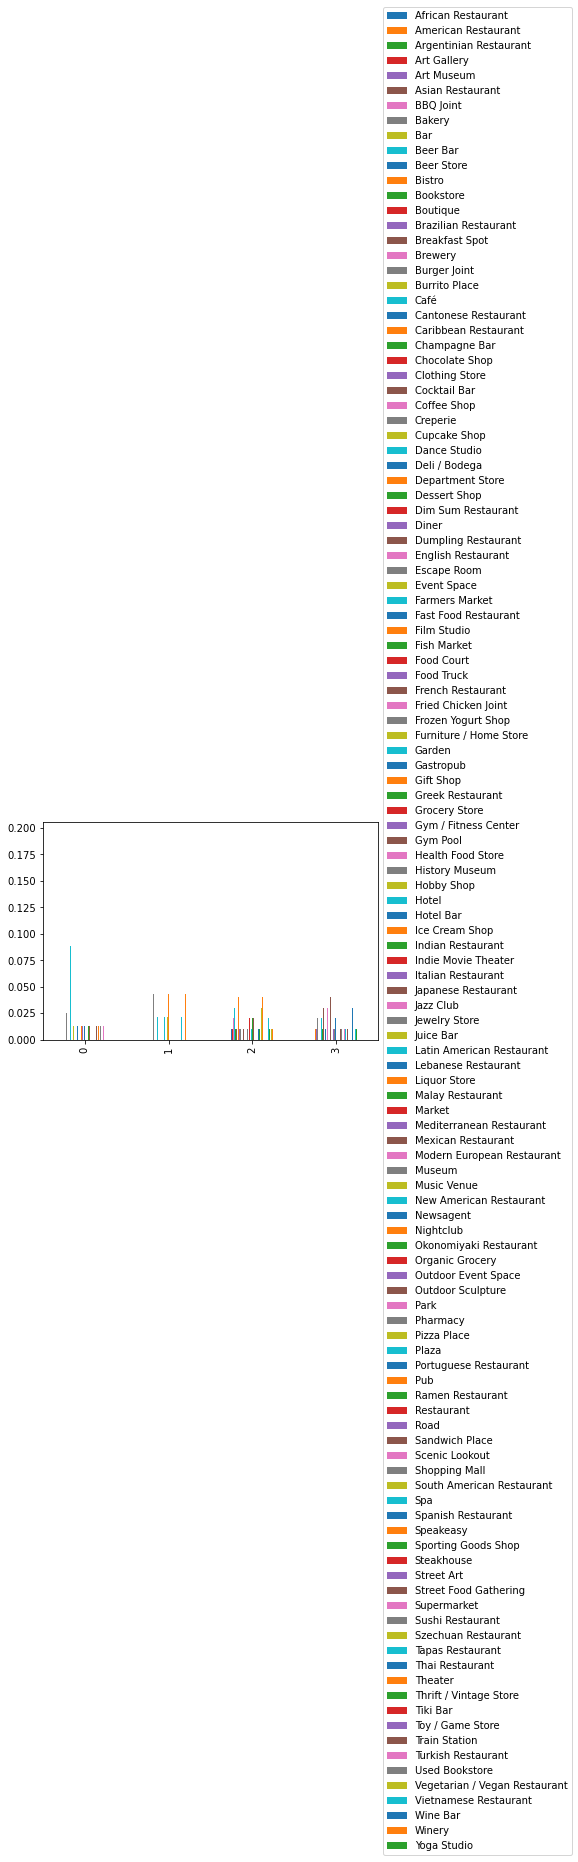

In [56]:
bar_chart = london_grouped #.iloc[0]
# print(bar_chart.transpose())

bar_chart.plot.bar().legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

### Look through each row and add the columns together (containing restaurant) to gain a total percentage

For each borough, we create a new 'total_restaurant_percentage' variable and wherever the word 'restaurant appears, we add all the column values where restaurant.

In [57]:

Restau_percent = {
    'Camden' : 0 ,
    'Islington' : 0 ,
    'Lambeth' : 0,
    'Southwark' : 0

    
}


for column in london_grouped.columns:
#     print(column)
    if "Restaurant" in column:
#         print("Hit at column: ",column)
        Restau_percent['Camden'] += london_grouped.iloc[0][column]
        Restau_percent['Islington'] += london_grouped.iloc[1][column]
        Restau_percent['Lambeth']+= london_grouped.iloc[2][column]
        Restau_percent['Southwark'] += london_grouped.iloc[3][column]
    
            





print("\n** Percentage of Restaurants at **\nCamden: {}, \nIslington: {}, \nLambeth: {}, \nSouthwark: {}".format(Restau_percent['Camden'], Restau_percent['Islington'], Restau_percent['Lambeth'], Restau_percent['Southwark']))


Restau_percent = sorted(Restau_percent, key=Restau_percent.get, reverse=True)

print("\n\n Looking at the data here is our recoomendation in order of places to go vs places not to go \n", Restau_percent)





** Percentage of Restaurants at **
Camden: 0.18987341772151903, 
Islington: 0.15217391304347827, 
Lambeth: 0.32000000000000006, 
Southwark: 0.28


 Looking at the data here is our recoomendation in order of places to go vs places not to go 
 ['Lambeth', 'Southwark', 'Camden', 'Islington']


## Removing all venues which aren't restaurants (our example):

In [58]:
# Do the same for venues and drop all that dont contain restaurant - this will be used for the heat map



for venue in filtered_london_venues['Venue Category']:
#     print("\n", venue)
    
    if "Restaurant" not in venue:
        #drop this row
#         print("\n ** HIT - {} not a restaurant".format(venue))
        filtered_london_venues = filtered_london_venues[~filtered_london_venues['Venue Category'].isin([venue])]


# print(filtered_london_venues.shape())       
filtered_london_venues.head()



,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Camden,51.529,-0.1255,Decimo,51.529627,-0.124469,Mexican Restaurant
11,Camden,51.529,-0.1255,Pitted Olive,51.526369,-0.125623,Turkish Restaurant
14,Camden,51.529,-0.1255,Casa Tua,51.527580,-0.123635,Italian Restaurant
24,Camden,51.529,-0.1255,Plum + Spilt Milk,51.530866,-0.124218,Restaurant
26,Camden,51.529,-0.1255,German Gymnasium,51.532392,-0.125267,Modern European Restaurant


# Pin and Heat Map

In [59]:
# create map
restaurant_options = folium.Map(location=[latitude, longitude], zoom_start=11)

folium.Circle(
    [latitude, longitude],
    radius= BusinessCriteria['Radius'],
    popup= "Limit Radius to set up shop",
    color= 'red',
    fill=True,
    fill_opacity = '10%',
    fill_color='red').add_to(restaurant_options)

# add markers to map
for lat, lng, venue in zip(filtered_london_venues['Venue Latitude'], filtered_london_venues['Venue Longitude'], filtered_london_venues['Venue']):
    
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(restaurant_options)  


restaurant_options



In [60]:
# heat map

from folium import plugins
from folium.plugins import HeatMap


restaurant_heat = folium.Map(location=[latitude, longitude], zoom_start=11)




# Ensure you're handing it floats
filtered_london_venues['Venue Latitude'] = filtered_london_venues['Venue Latitude'].astype(float)
filtered_london_venues['Venue Longitude'] = filtered_london_venues['Venue Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs faster
heat_df = filtered_london_venues[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(restaurant_heat)

# Display the map
restaurant_heat

### Top Venues

In [61]:
num_top_venues = 5

for hood in london_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Camden----
                        venue  freq
0                       Hotel  0.10
1                 Coffee Shop  0.10
2                        Café  0.09
3                         Pub  0.08
4  Modern European Restaurant  0.03


----Islington----
            venue  freq
0             Pub  0.20
1  Ice Cream Shop  0.04
2     Music Venue  0.04
3            Café  0.04
4    Cocktail Bar  0.04


----Lambeth----
                  venue  freq
0                Market  0.04
1           Coffee Shop  0.04
2  Caribbean Restaurant  0.04
3                   Pub  0.04
4            Restaurant  0.03


----Southwark----
               venue  freq
0        Coffee Shop  0.10
1                Pub  0.05
2                Bar  0.05
3      Grocery Store  0.04
4  French Restaurant  0.04




## Heat map of the restaurants in those areas